In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import jax
import jax.numpy as jnp
from evosax import CMA_ES, SimAnneal

from envs.photon_env import BatchedPhotonLangevinReadoutEnv

In [12]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.1
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 6.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 8
num_updates = 2000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [13]:
env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=batchsize,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)

In [14]:
# Instantiate the search strategy
rng = jax.random.PRNGKey(0)
strategy = CMA_ES(popsize=batchsize, num_dims=env.num_actions, elite_ratio=0.5)
es_params = strategy.default_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu)
es_params

EvoParams(mu_eff=Array(17.62165241, dtype=float64), c_1=Array(0.00029451, dtype=float64), c_mu=Array(0.00454011, dtype=float64), c_sigma=Array(0.18935861, dtype=float64), d_sigma=Array(1.18935861, dtype=float64), c_c=Array(0.04936556, dtype=float64), chi_n=Array(8.97228754, dtype=float64, weak_type=True), c_m=1.0, sigma_init=1.0, init_min=-1, init_max=1, clip_min=-2.3255813953488373, clip_max=2.3255813953488373)

In [15]:
# Simulated Annealing

sim_anneal = SimAnneal(popsize=batchsize, num_dims=env.num_actions)
sim_params = sim_anneal.default_params
sim_params = sim_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu)

In [16]:
def custom_rollout(batch_actions):
    res_drive = env.a0 * batch_actions.astype(jnp.float64)
    normalizing_factor = jnp.clip(
        env.mu * env.a0 / jnp.absolute(res_drive),
        0.0,
        1.0,
    )
    res_drive *= normalizing_factor
    res_drive = env.batched_smoother(res_drive)

    batch_res = env.batched_results(res_drive)
    reward, _ = env.batched_reward_and_state(
        batch_res.astype(env.float_dtype), res_drive
    )

    fitness = -reward # Since we are dealing with minimisation

    return fitness.astype(jnp.float32)

In [17]:
import time

state = sim_anneal.initialize(rng, sim_params)

start = time.time()
fitness_list = []

# Run ask-eval-tell loop - NOTE: By default minimization
for t in range(int(2e4)):
    rng, rng_gen, rng_eval = jax.random.split(rng, 3)
    x, state = sim_anneal.ask(rng_gen, state, sim_params)
    fitness = custom_rollout(x)
    state = sim_anneal.tell(x, fitness, state, sim_params)
    fitness_list.append(state.best_fitness)

    if (t + 1) % 100 == 0:
        # print("CMA-ES - # Gen: {}|Fitness: {:.5f}|Params: {}".format(
        #     t+1, state.best_fitness, state.best_member))
        print("CMA-ES - # Gen: {}|Fitness: {:.5f}".format(
            t+1, state.best_fitness))
        print(f"Time: {time.time() - start}")

CMA-ES - # Gen: 100|Fitness: 102.91648
Time: 6.294479846954346
CMA-ES - # Gen: 200|Fitness: 102.91100
Time: 7.505695819854736
CMA-ES - # Gen: 300|Fitness: 102.91100
Time: 8.667389869689941
CMA-ES - # Gen: 400|Fitness: 0.02881
Time: 9.807759761810303
CMA-ES - # Gen: 500|Fitness: -2.20648
Time: 10.95104169845581
CMA-ES - # Gen: 600|Fitness: -2.25151
Time: 12.130968809127808
CMA-ES - # Gen: 700|Fitness: -4.56793
Time: 13.265870809555054
CMA-ES - # Gen: 800|Fitness: -5.56590
Time: 14.42023491859436
CMA-ES - # Gen: 900|Fitness: -8.86942
Time: 15.555680751800537
CMA-ES - # Gen: 1000|Fitness: -9.70451
Time: 16.722484827041626
CMA-ES - # Gen: 1100|Fitness: -10.26992
Time: 17.85546875
CMA-ES - # Gen: 1200|Fitness: -13.15278
Time: 18.988609790802002
CMA-ES - # Gen: 1300|Fitness: -15.00852
Time: 20.11644959449768
CMA-ES - # Gen: 1400|Fitness: -16.20973
Time: 21.245898962020874
CMA-ES - # Gen: 1500|Fitness: -16.23869
Time: 22.379424571990967
CMA-ES - # Gen: 1600|Fitness: -16.23869
Time: 23.7197487

KeyboardInterrupt: 

[-2.3255814  -2.1465358  -2.30941717 -2.31801828 -2.3255814  -2.26885368
 -2.3255814  -2.3255814  -2.26864368 -2.3255814  -2.13849989 -2.2465235
 -2.29351577 -2.27272262 -1.77569446 -1.60885359 -1.77600738  0.21028487
 -1.66876908 -0.71095885 -0.92356331 -2.03634846 -0.12363921  0.1069629
  1.1080312   1.89979238  2.3255814   2.27992458  2.3255814   2.3255814
  2.30835854  1.88746138  1.85976842  2.23370066  0.9035569   2.04068347
  1.40304485 -0.3426988   1.34636859  0.21875199 -0.20513686 -0.06016602
 -1.63900676 -0.43280498 -0.56080806 -1.57026544 -1.20844387 -1.68241504
 -0.36383265 -0.98752549  0.29385491 -0.33825056  0.75392627 -1.03371318
 -0.05626917 -1.11547513 -0.55719991 -1.04588168 -0.90821093  0.2875807
 -0.241532   -0.69843236  1.41366227 -0.23117236  0.87191745  1.07592755
 -0.15098256  0.91081208 -0.67670629  0.0199688  -0.78869336 -0.67435151
 -1.56630689 -0.17560061 -1.98670685 -0.36246668  0.03491611 -0.51471718
  0.44700739 -0.76304403  0.4781494 ]


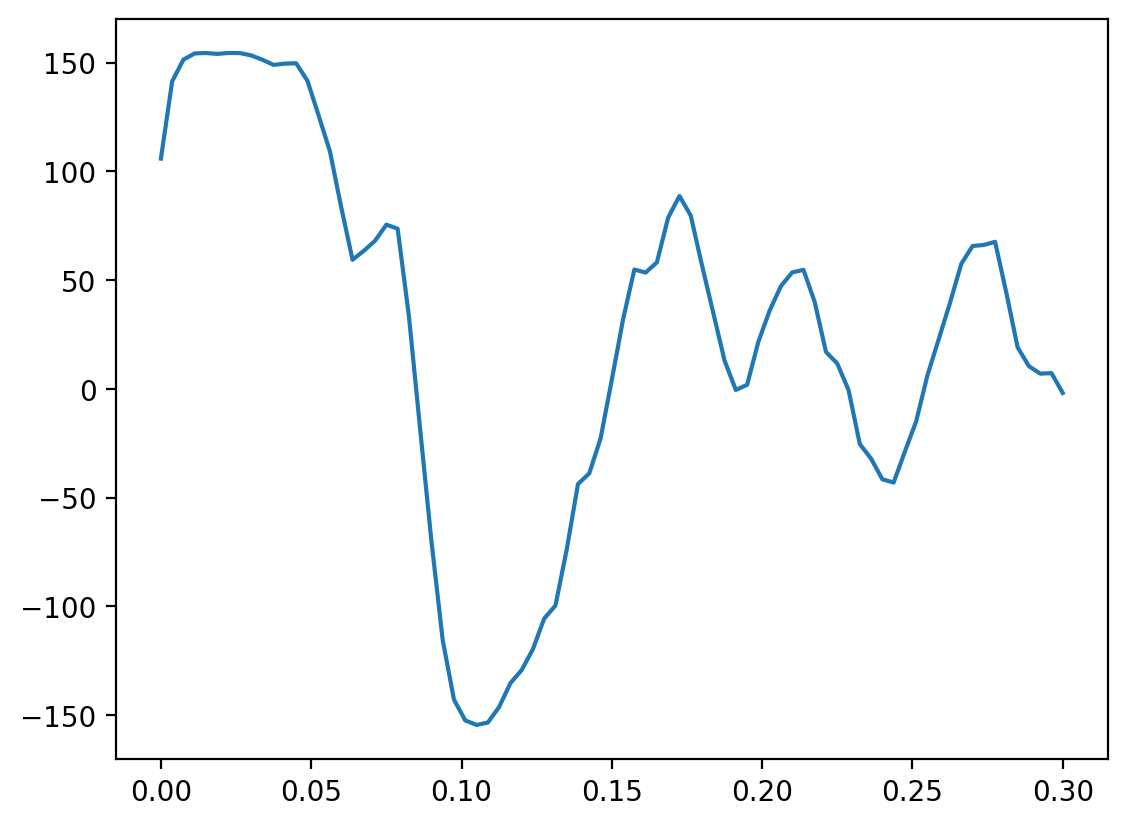

In [18]:
import matplotlib.pyplot as plt

action = state.best_member
action *= env.a0
action = -env.drive_smoother(action)

print(state.best_member)
plt.plot(env.ts_action, action)
plt.show()

In [19]:
batched_action = jnp.tile(action, (batchsize, 1))

batched_res = env.batched_results(batched_action)
(
    max_pf,
    max_photons,
    photon_reset_time,
    pulse_end_times,
    max_pf_times,
    smoothness_vals,
    b_pf,
    b_higher_photons,
    _
) = env.batched_extract_values(batched_res, batched_action)

reward, _ = env.batched_reward_and_state(
    batched_res,
    batched_action
)

print(max_pf_times[0])
print(photon_reset_time[0])
print(reward[0])

0.09583333333333335
0.1716666666666667
17.44219289683617


0.0871958638006408
206
0.0871958638006408
206


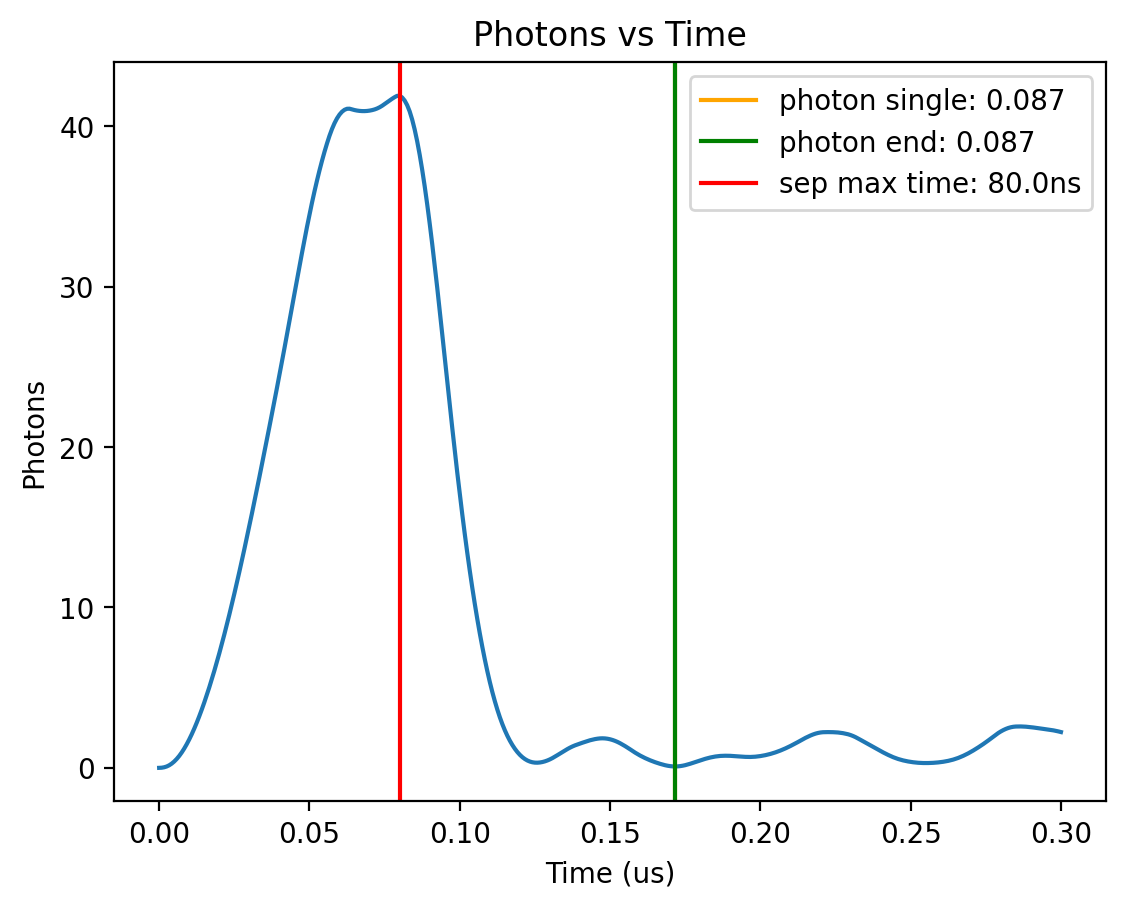

In [20]:
single_photon = b_higher_photons[0]

single_res = batched_res[0]
g_real, g_imag, e_real, e_imag = single_res.T
single_sep = jnp.sqrt((g_real - g_imag) ** 2 + (e_real - e_imag) ** 2)

single_photon = g_real ** 2 + g_imag ** 2

ext = 50
ext_15 = 300
ext_2 = -1

min_photon = jnp.min(single_photon[ext:ext_2])
argmin = jnp.argmin(single_photon[ext:ext_2]) + ext

min_photon_2 = jnp.min(single_photon[ext:ext_15])
argmin_2 = jnp.argmin(single_photon[ext:ext_15]) + ext

argmax = jnp.argmax(single_sep)

print(min_photon)
print(argmin)

print(min_photon_2)
print(argmin_2)

plt.plot(env.ts_sim, single_photon)
plt.axvline(x=env.ts_sim[argmin_2], label=f'photon single: {int(1e3*min_photon_2)/1e3}', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'photon end: {int(1e3*min_photon)/1e3}', color='green')
plt.axvline(x=env.ts_sim[argmax], label=f'sep max time: {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.xlabel('Time (us)')
plt.ylabel('Photons')
plt.title('Photons vs Time')
plt.legend()
plt.show()

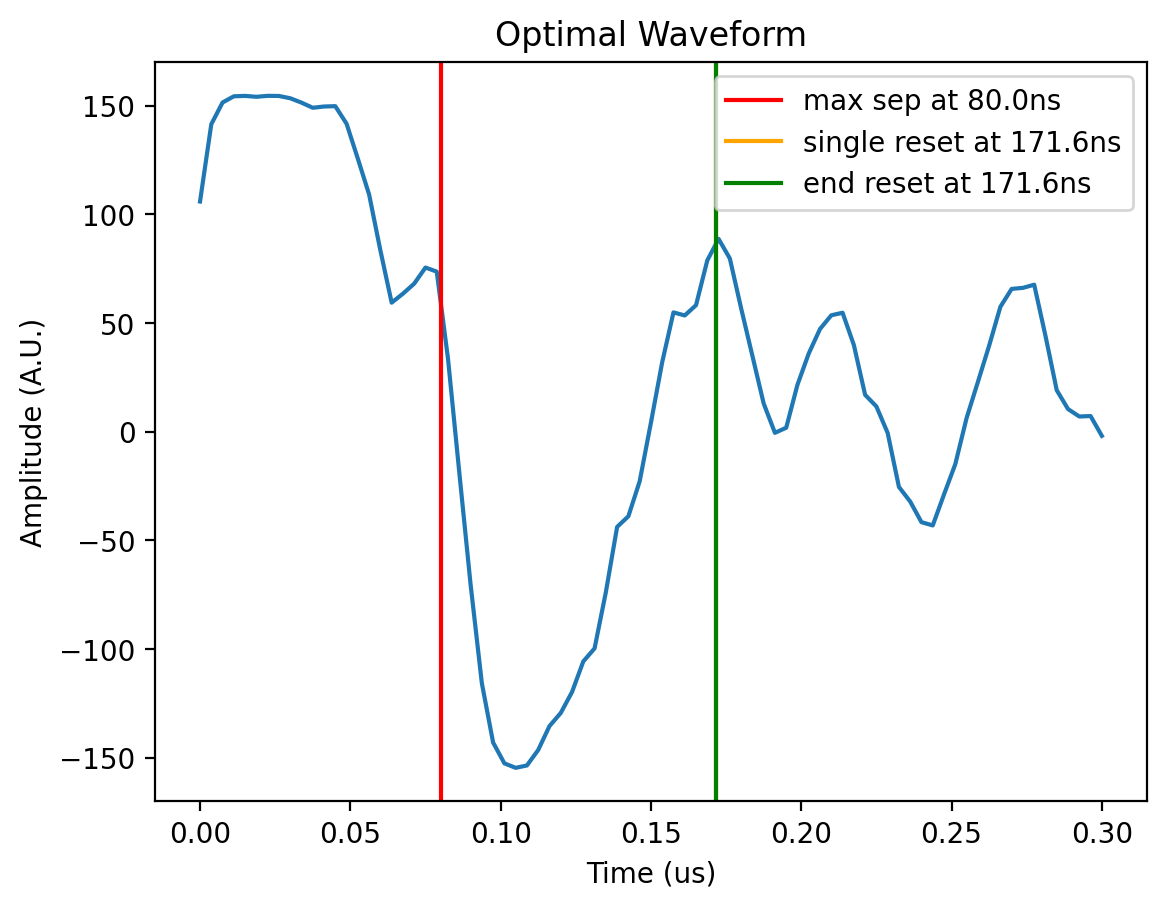

In [21]:
plt.plot(env.ts_action, action)
plt.axvline(x=env.ts_sim[argmax], label=f'max sep at {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.axvline(x=env.ts_sim[argmin_2], label=f'single reset at {int(1e4*env.ts_sim[argmin_2])/1e1}ns', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'end reset at {int(1e4*env.ts_sim[argmin])/1e1}ns', color='green')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.title('Optimal Waveform')
plt.legend()
plt.show()

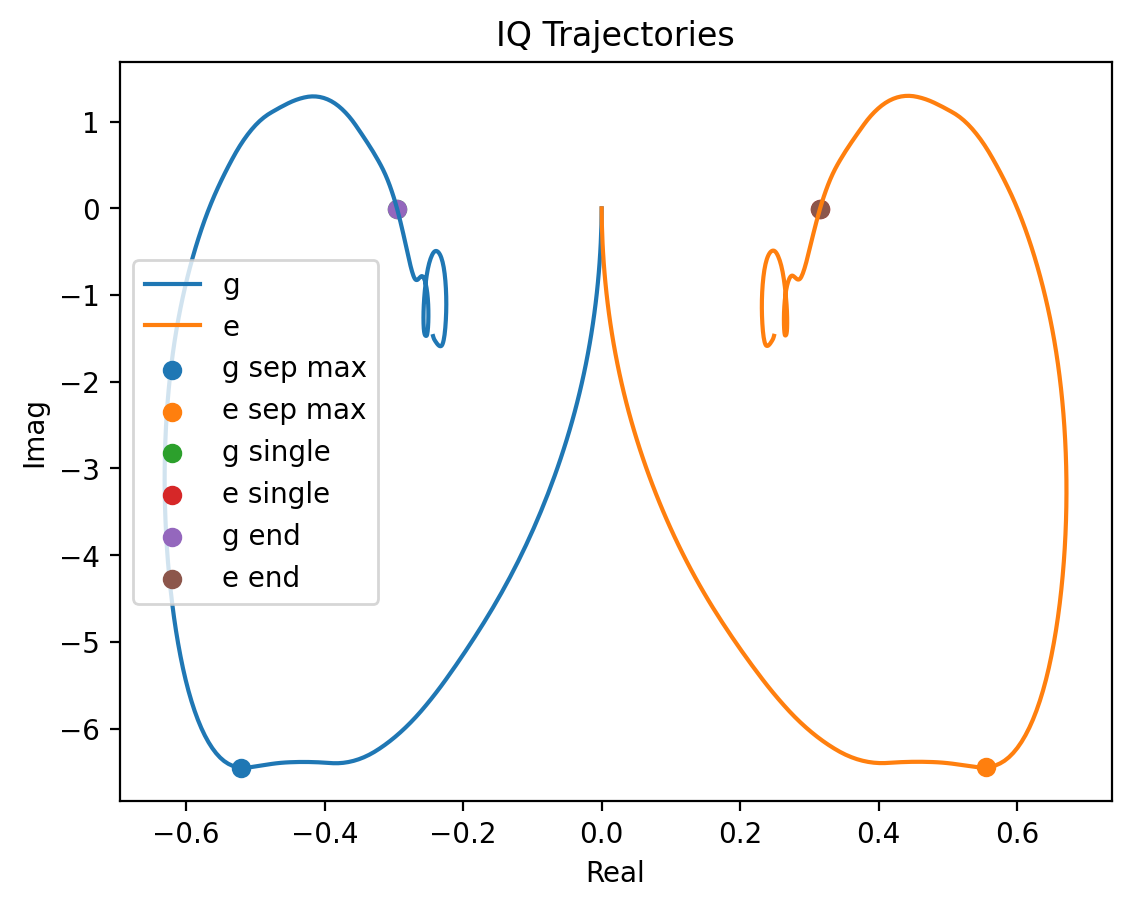

In [22]:
plt.plot(g_real, g_imag, label='g')
plt.plot(e_real, e_imag, label='e')
plt.scatter(g_real[argmax], g_imag[argmax], label='g sep max')
plt.scatter(e_real[argmax], e_imag[argmax], label='e sep max')
plt.scatter(g_real[argmin_2], g_imag[argmin_2], label='g single')
plt.scatter(e_real[argmin_2], e_imag[argmin_2], label='e single')
plt.scatter(g_real[argmin], g_imag[argmin], label='g end')
plt.scatter(e_real[argmin], e_imag[argmin], label='e end')
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title('IQ Trajectories')
plt.legend()
plt.show()

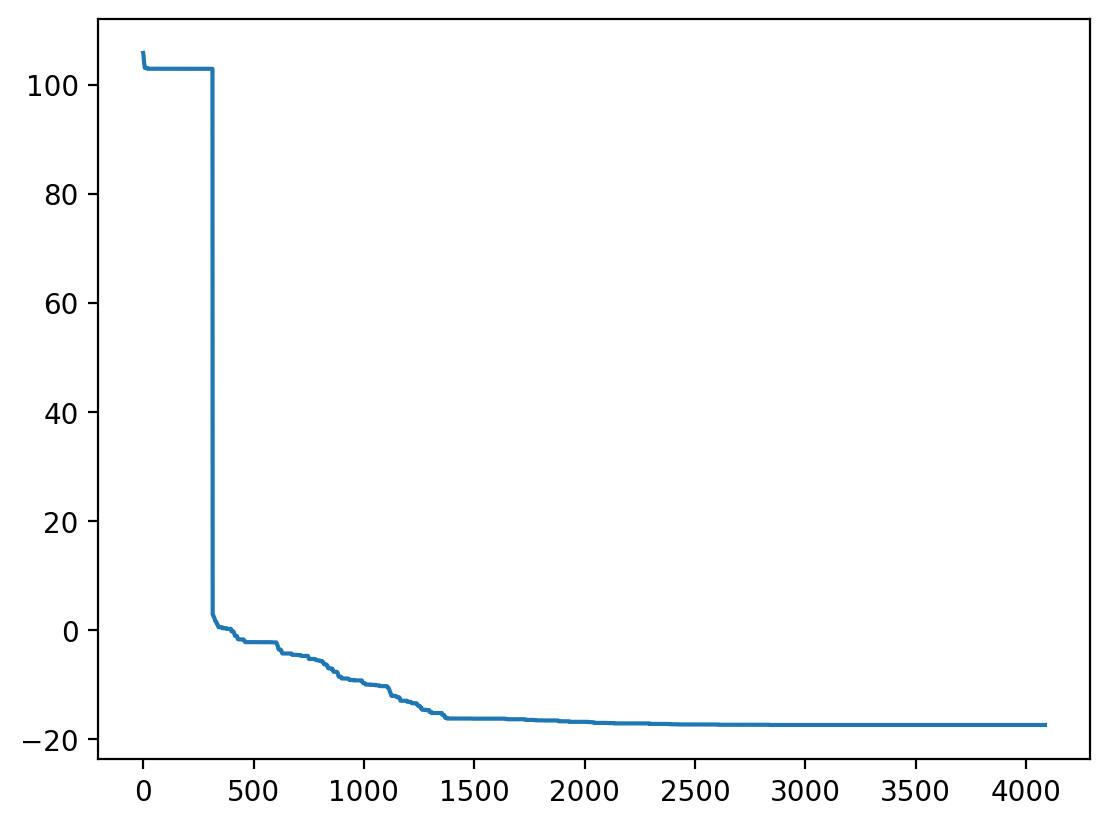

In [23]:
plt.plot(fitness_list)